# 10.2 Epipolar geometry

Epipolar geometry is the geometry of stereo vision. When two cameras view a 3D scene from two different positions, there are a number of geometric relations between the 3D points and their projections onto the 2D images that lead to constraints between the image points. These relations are derived based on the assumption that the cameras can be approximated by the pinhole camera model. $\\[10pt]$

<img src="./images/epipolar.png" width="400" />$\\[10pt]$

In this notebook, we will go deeper into epipolar geometry, learning:

- Basic concepts of epipolar geometry
- Stereo rectification
- Essential matrix
- Fundamental matrix

## Problem context - Stereo rectification

In practice, triangulation is not feasible as stereo systems doesn't fulfill the ideal configuration. Before triangulation, stereo rectification or **image rectification** is needed. Here, we apply homographies to the left and right images in order to force this ideal configuration.$\\[10pt]$

<img src="./images/rectification.png" width="600" />

Image rectification is based in epipolar geometry. Fortunately, we will learn how it works here below.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

images_path = './images/'

import sys
sys.path.append("..")
from utils.drawlines import drawlines

## Concepts of epipolar geometry

Before starting to explain how epipolar geometry works, we have to understand some basic concepts:

<img src="./images/epipolar1.png" width="600" />

First of all, we have the **epipolar plane**. This plane is formed by 3 points: the left and right focal points ($C_l,\ C_r$), and a point of the world ($X$). 

The interesting thing about the epipolar plane, is that it intersects the images at the **conjugate epipolar lines** of the StereoVision System. The projections of the point $X$ are contained in their corresponding epipolar line. In this way, it would be interesting to know how to compute these epipolar lines because we can check if a match of points is correct or not (to find the matching point in other image, you don't need to search the whole image, just search along the line). This is called **Epipolar Constraint**. In the same way, all points will have its corresponding epilines in the other image.

*Given a two-camera configuration (represented by $R,t$), for each 3D point there is a **unique epipolar plane** and, consequently, a **unique pair of epipolar lines**.* 

You can notice that all epipolar lines intersect in one point, this point is called the **epipole**, and it is the projection of the focal point of a camera on the other image plane (may be outside the boundary of the image). All the epilines pass through its epipole. So to find the location of epipole, we can find many epilines and find their intersection point.:

<img src="./images/epipolar2.png" width="600" />

The epipoles are the most interesting points in epipolar geometry because once they are located, it is possible to find all epipolar lines. There are some special cases where one or both epipoles are in the infinity (if the image plane is parallel to the line $C_l-C_r$):

<img src="./images/epipolar3.png" width="800" />

Anyways, in these cases, we can compute the direction in which the epipole can be found:

<img src="./images/epipolar4.png" width="800" />

### Where are the epipoles?

First of all, let's find the coordinates of left camera frame $C_l$ in the world frame $C_W$: (we assume that world frame is at the left camera $\rightarrow C_l = \bf {0}$)$\\[10pt]$

<img src="./images/epipolar5.png" width="400" align="left"/>

$$\begin{cases} C_l = R_W^l C_W + t_W^l \\[10pt]  C_l = \begin{bmatrix}0\\0\\0 \end{bmatrix} = \bf{0}\end{cases} \longrightarrow 0 = R_W^l C_W + t_W^l \rightarrow C_W = -(R_W^l)^Tt_W^l\\[20pt]$$

$$\text{As world frame is assumed at the left camera: } R_W^l = I, \; t_W^l = \mathbf{0}\\[5pt]
\text{So, the right optical center: } C_{r,W} = -(R_r^l)^Tt_r^l = -R^Tt\hspace{2cm} \\[10pt]$$

**Epipoles**

For finding the epipoles, we have to find the projection of a optical center on the other image plane ($e'$ means the epipole coordinates in pixels):$\\[5pt]$

$$\text{Left epipole } e_l:  \lambda\tilde{e}'_l = P_l \tilde{C}_{r,W} = K_l [I|0][-R^Tt1]^T = -K_l R^T t\\
\text{Right epipole } e_r:  \lambda\tilde{e}'_r = P_r \tilde{C}_{l,W} = K_r [R|t][\mathbf{0}\ 1]^T = K_r t \hspace{1.4cm}
\\[5pt]$$

Let's find the epipoles in the ideal configuration for triangulation (parallel cameras separated by a baseline with same intrinsic parameters):$\\[5pt]$

$$R = I,\quad t = [-b\ 0 \ 0]^T, K = K_l = K_r\\[3pt]
\lambda\tilde{e}'_l = -Kt = [bk_xf \quad 0 \quad 0]^T\\
\lambda\tilde{e}'_r = Kt = [-bk_xf \quad0 \quad 0]^T$$

## Stereo rectification

In practise, our camera configuration is not ideal ($R \ne I \wedge t \ne [-b\ 0 \ 0]^T \wedge K_l \ne K_r$). This implies a dificulty for finding correspondences and triangulation (it requieres ideal configuration):

<img src="./images/non-rectified.png" width="400" />

As you can see, **epipolar lines are not horizontal** (ideal configuration). Stereo rectification projects the images on a common plane such the epipolar lines are horizontal in both images and at the same height. Thus, **epipoles are at infinity**, we can compute a homography for each camera in the system that transform images to the ideal configuration:

<img src="./images/rectified.png" width="400" />

#### <font color="orange">OpenCV pill</font>

openCV defines a method for image rectification ([cv2.stereoRectify](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6)), which computes the rotation matrices for each camera that (virtually) make both camera image planes the same plane. This method asks for the matrices $R_r^l$ and $t_r^l$, then applies the camera model to compute the rotation matrices. As we don't have a stereo system that have a fixed relative pose, we cant obtain those matrices (they could be obtained through [stereo calibration](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#ga91018d80e2a93ade37539f01e6f07de5)).

Fortunately, there exists the method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052), which returns the rectification homographies for both images having a set of matching points and the **fundamental matrix** (explained later). This method is used when you don't know the relative pose of the cameras that captured the photos (e.g. two images taken with the same camera in different positions).

## Essential matrix

At the beggining of the notebook, we told that all points will have a corresponding epipolar line in the other image. **The Essential Matrix (E)** is a $3 \times 3$ matrix that encodes epipolar geometry. Given a point in one image, multiplying by the essential matrix will tell us the epipolar line in the second view:

$$l_l = E\tilde{x_r}$$

<img src="./images/essential.png" width="600" />

**How to compute the essential matrix?**

<img src="./images/essential2.png" width="800" />

Vectors $\mathbf{X_l}, \mathbf{t}$ and $ \mathbf{RX_r}$ are coplanar $\Rightarrow$ their triple product is zero:$\\[5pt]$

$$X_l \cdot [t \times (RX_r)] = 0 \xrightarrow{\text{X} = \lambda \tilde{x}} \tilde{x}^T_l \cdot [t \times (R \tilde{x}_r)] = 0 \Longrightarrow \large{\mathbf{\tilde{x}^T_l E \tilde{x}_r = 0} \text{ with } \mathbf{E = [t]_\times R}}\\[10pt] [t]_\times = \begin{bmatrix} 0 & -t_x & t_y \\ t_x & 0 & -t_x \\ -t_y & t_x & 0 \end{bmatrix}\\[10pt]$$

The problem of this matrix is that we are working in sensor coordinates (meters), the cameras need to be calibrated in order to transforming to pixels ($K$ must be known, assuming identical intrinsic parameters):

$$\tilde{x}_r' = K\tilde{x}_r \\ \tilde{x}_l' = K\tilde{x}_l$$

## Fundamental matrix

**Fundamental matrix (F)** is similar to the essential matrix, but works in the image plane instead of sensor coordinates:

$$\tilde{x}'^T_l F \tilde{x}'_r = 0$$

We can obtain the fundamental matrix from the essensial one:

$$\tilde{x}^T_l E \tilde{x}_r = \left( K^{-1}\tilde{x}'_l \right)^T [t]_\times R K^{-1} \tilde{x}'_r = \tilde{x}'^T_l K^{-T} [t]_\times R K^{-1} \tilde{x}'_r = \tilde{x}'^T_l F \tilde{x}'_r = 0\\[10pt] \mathbf{F = K^{-T} [t]_\times R K^{-1}}\\[1pt]$$

The good thing about working in the image plane, is that we can obtain the matrix $F$ from 8 pairs of points in both images (no need to know $K$).

The fundamental matrix is the cornerstone of epipolar geometry, as it allow us to compute the epipoles and relate points and lines:

### Relate two points:

We can check if a correspondence of points is valid (points are contained in corresponding epipolar lines)

$$\tilde{x}'^T_l F \tilde{x}'_r = 0$$

### Relate points with epipolar lines:

It's also possible to find the corresponding epipolar line of a point

$$l'_l = F \tilde{x}'_r$$

### Compute epipoles:

As the epipole is the intersection point of all epipolar lines

$$\tilde{x}'^T_l F \tilde{e}'_r = 0,  \quad \forall \tilde{x}'_l\\
F \tilde{e}'_r = 0
$$

### **<span style="color:green"><b><i>ASSIGNMENT 1a</i></b></span>**

In this task, we are going to rectify two images using the previous mentioned method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052). You should take two images of the same scene from different positions, replicating a stereo system. Also, you can use images `iml.png` (left) and `imr.png` (right) if you can't use your own images.

The first step for image rectification is **finding the fundamental matrix**, for this we need a set of matching points. You should use your keypoint detector + descriptor in order to get this (we recomend **ORB for big images**).

openCV defines a method for computing the fundamental matrix ([cv2.findFundamentalMat](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#gae420abc34eaa03d0c6a67359609d8429)) from two lists of matching points (in coordinates, not `cv2.keyPoint()` objects). The method returns an argument `mask`, which returns the points used for matrix calculation.

**What to do?** Compute the fundamental matrix that relates the epipolar geometry between your images and show it.

In [6]:
# Read left image
im_l = cv2.imread(images_path + "iml2.jpg") #queryimage
im_l = cv2.cvtColor(im_l, cv2.COLOR_BGR2RGB)

# Read right image
im_r = cv2.imread(images_path + "imr2.jpg")  #trainimage
im_r = cv2.cvtColor(im_r, cv2.COLOR_BGR2RGB)

# Get gray images
gray_l = cv2.cvtColor(im_l,cv2.COLOR_RGB2GRAY)
gray_r = cv2.cvtColor(im_r,cv2.COLOR_RGB2GRAY)

# Detect the ORB keypoints using the OpenCV method
# -- create the ORB detector
orb = cv2.ORB_create()

# -- detect ORB keypoints 
kp_l = orb.detect(gray_l,None)
kp_r = orb.detect(gray_r,None)

# -- compute the descriptors with ORB
kp_l, des_l = orb.compute(gray_l, kp_l)
kp_r, des_r = orb.compute(gray_r, kp_r)

# Match descriptors.
matches = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(des_l,des_r)

# Create lists of corresponding keypoints
pts_l = []
pts_r = []
for match in matches:
    pts_l.append(kp_l[match.queryIdx].pt)
    pts_r.append(kp_r[match.trainIdx].pt)
    
# Cast to integers
pts_l = np.int32(pts_l)
pts_r = np.int32(pts_r)

# Compute fundamental matrix
F, mask = cv2.findFundamentalMat(pts_l,pts_r,cv2.FM_LMEDS)

print(F)

[[ 1.29074579e-07  3.98308594e-07 -6.01565344e-04]
 [-4.95013352e-07  3.42725073e-07  1.03929537e-03]
 [ 1.22415103e-04 -1.93917078e-03  1.00000000e+00]]


### **<span style="color:green"><b><i>ASSIGNMENT 1b</i></b></span>**

Now, we can **compute the homographies** needed for rectify the images with the method [cv2.stereoRectifyUncalibrated](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html#gaadc5b14471ddc004939471339294f052), which takes the lists of matching points used in the previous method, the fundamental matrix and the shape of the images.

**What to do?** Rectify your images applying the needed homography and show them.

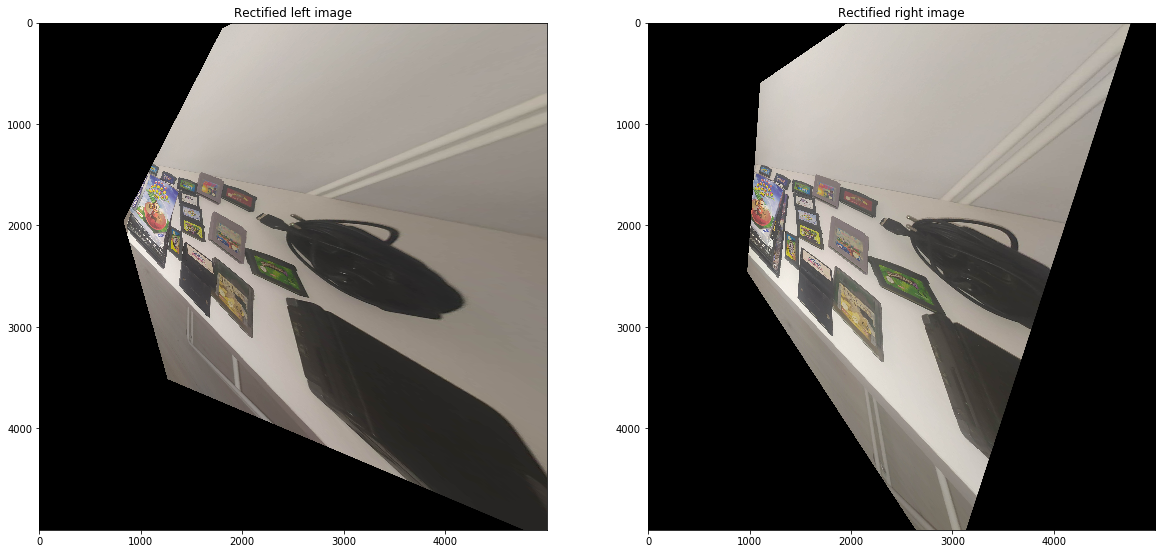

In [9]:
# Obtain homographies
ret, H_l, H_r = cv2.stereoRectifyUncalibrated(pts_l,pts_r, F, gray_r.shape)

# Apply homographies
rectified_l = cv2.warpPerspective(im_l, H_l, (5000,5000))
rectified_r = cv2.warpPerspective(im_r, H_r, (5000,5000))

# Show rectified images
plt.subplot(121)
plt.title("Rectified left image")
plt.imshow(rectified_l)
plt.subplot(122)
plt.title("Rectified right image")
plt.imshow(rectified_r)

### **<span style="color:green"><b><i>ASSIGNMENT 2</i></b></span>**

Having the fundamental matrix, we can also calcule the epipolar lines that correspond to any point. Method [cv2.computeCorrespondEpilines](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga19e3401c94c44b47c229be6e51d158b7) facilitates this, its inputs are:

- `points`: set of input points of which corresponding epipolar lines will be computed
- `whichImage`: index of the image (1 for left or 2 for right) that contains the points
- `F`: fundamental matrix

It returns the coefficients of the epipolar lines in a ($n\_points \times 1 \times 3$) matrix.

For showing the epipolar lines, we have defined a method `drawlines` (in utils). This method draws the lines in one image, and their corresponding keypoints (with the same color) in the other image, its inputs are:

- `im_points`: input image in which the points are going to be drawn
- `pts`: array containing the points' coordinates ($n\_points \times 2$) of `im_points`
- `im_lines`: input image in which the epipolar lines are going to be drawn
- `lines`: coefficients of the epipolar lines drawn in `im_lines` 
- `size`: size of drawn elements (default 5), change this if you can't see the lines and points or they are too big.

It returns two images, `im_lines` (where lines have been drawn) and `im_points` (where points have been drawn).

**What to do?** Calcule the **epipolar lines of the keypoints detected in the right image** previouly. Then, **draw the epipolar lines in the left image** and the points in the right image.

Finally, print both images.

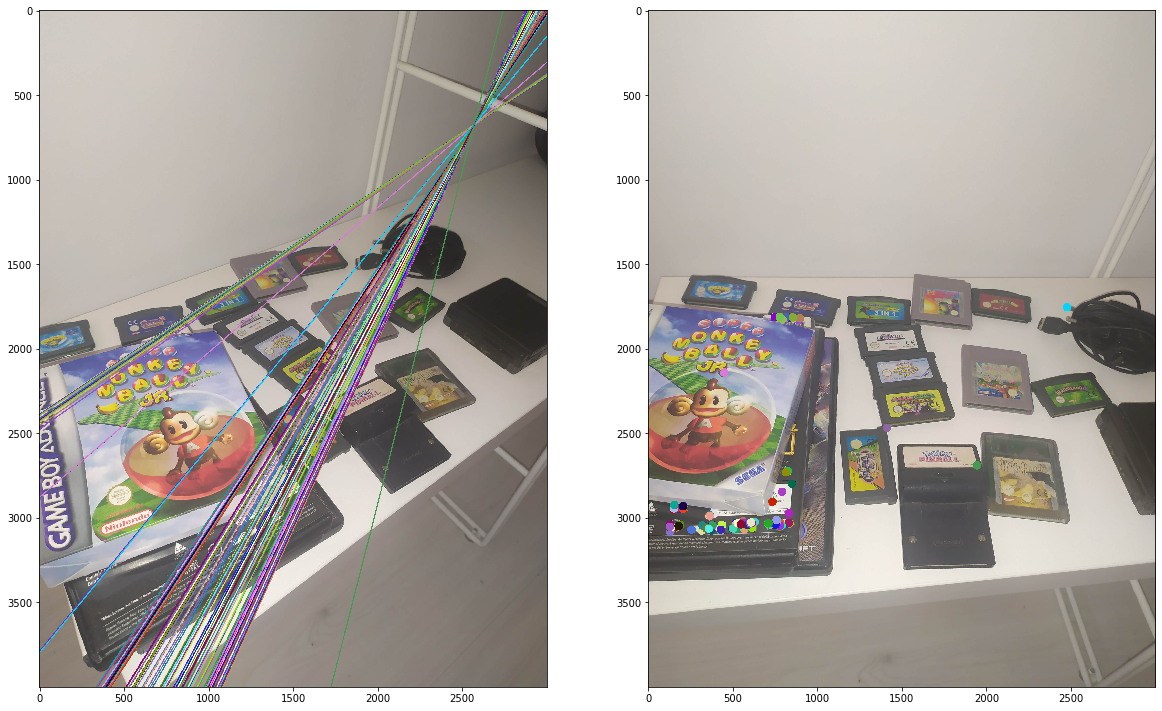

In [4]:
# Find epilines corresponding to points in left image
lines_l = cv2.computeCorrespondEpilines(pts_r.reshape(-1,1,2), 2,F)
lines_l = lines_l.reshape(-1,3)

# Draw epipolar lines
epipolar_l, epipolar_r = drawlines(im_r,pts_r,im_l,lines_l,5)

# Print images
plt.subplot(121)
plt.imshow(epipolar_l)
plt.subplot(122)
plt.imshow(epipolar_r)

## Conclusion

Brilliant! Note that if we had a fixed stereo system, the fundamental matrix would be constant for any pair of images. Anyway, once rectification have been applied, triangulation is more precise, so depth images are!

In this notebook, we have learn:

- fundamentals of epipolar geometry
- stereo rectification for uncalibrated and calibrated cameras
- finding the fundamental matrix from a pair of images